# Approach 3: Feature Engineering

## Spotify Song Popularity Prediction

**Improvement Strategy:** Build on Approach 1 (best so far) and add feature engineering techniques:
- Polynomial features
- Interaction terms
- Feature ratios
- Binning/discretization

---

### Previous Results:
| Approach | CV RMSE | Val R² |
|----------|---------|--------|
| Baseline (no genre) | 11.27 | 0.39 |
| **Approach 1 (top 15 separate)** | **10.93** | **0.41** |
| Approach 2 (hybrid groups) | 11.05 | 0.35 |

**Goal:** Improve upon Approach 1's CV RMSE of 10.93

---
## 1. Import Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


---
## 2. Load and Prepare Data (Same as Approach 1)

In [2]:
# Load data
train_df = pd.read_csv('./data/CS98XRegressionTrain.csv')
test_df = pd.read_csv('./data/CS98XRegressionTest.csv')

# Handle missing genres
train_df['top genre'] = train_df['top genre'].fillna('Unknown').replace('', 'Unknown')
test_df['top genre'] = test_df['top genre'].fillna('Unknown').replace('', 'Unknown')

print("="*60)
print("DATA LOADED")
print("="*60)
print(f"Training set: {train_df.shape[0]} rows, {train_df.shape[1]} columns")
print(f"Test set:     {test_df.shape[0]} rows, {test_df.shape[1]} columns")

DATA LOADED
Training set: 453 rows, 15 columns
Test set:     114 rows, 14 columns


In [3]:
# Apply Approach 1's genre encoding (top 15 genres)
TOP_N_GENRES = 15
top_genres = train_df['top genre'].value_counts().head(TOP_N_GENRES).index.tolist()

def encode_genres(df, top_genres):
    df = df.copy()
    df['genre_simplified'] = df['top genre'].apply(
        lambda x: x if x in top_genres else 'other'
    )
    genre_dummies = pd.get_dummies(df['genre_simplified'], prefix='genre')
    df = pd.concat([df, genre_dummies], axis=1)
    return df

train_encoded = encode_genres(train_df, top_genres)
test_encoded = encode_genres(test_df, top_genres)

# Ensure same columns
train_genre_cols = [col for col in train_encoded.columns if col.startswith('genre_') and col != 'genre_simplified']
for col in train_genre_cols:
    if col not in test_encoded.columns:
        test_encoded[col] = 0

print(f"Applied Approach 1 genre encoding: {len(train_genre_cols)} genre features")

Applied Approach 1 genre encoding: 16 genre features


---
## 3. Feature Engineering

Now let's create new features to capture more complex relationships.

In [4]:
# Original numerical features
numerical_features = ['bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch']

print("="*60)
print("FEATURE ENGINEERING")
print("="*60)
print("\nOriginal numerical features:")
print(numerical_features)

FEATURE ENGINEERING

Original numerical features:
['bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch']


In [5]:
def engineer_features(df):
    """
    Create engineered features from the original numerical features.
    """
    df = df.copy()
    
    # =============================================
    # 1. INTERACTION TERMS (multiply related features)
    # =============================================
    
    # Energy-related interactions
    df['nrgy_x_dnce'] = df['nrgy'] * df['dnce']  # High energy + danceable
    df['nrgy_x_val'] = df['nrgy'] * df['val']    # Energy + positivity
    df['nrgy_x_dB'] = df['nrgy'] * df['dB']      # Energy + loudness
    
    # Danceability interactions
    df['dnce_x_val'] = df['dnce'] * df['val']    # Danceable + positive
    df['dnce_x_bpm'] = df['dnce'] * df['bpm']    # Danceable + tempo
    
    # Acoustic vs electronic
    df['acous_x_nrgy'] = df['acous'] * df['nrgy']  # Acoustic energy
    
    # =============================================
    # 2. RATIOS (relative measures)
    # =============================================
    
    # Avoid division by zero
    df['nrgy_per_bpm'] = df['nrgy'] / (df['bpm'] + 1)  # Energy efficiency
    df['dnce_per_nrgy'] = df['dnce'] / (df['nrgy'] + 1)  # Dance per energy
    df['val_per_nrgy'] = df['val'] / (df['nrgy'] + 1)    # Mood per energy
    df['spch_per_dur'] = df['spch'] / (df['dur'] + 1)    # Speech density
    
    # =============================================
    # 3. POLYNOMIAL FEATURES (squared terms for top correlated)
    # =============================================
    
    # Based on correlation analysis, these features are most important
    df['dur_squared'] = df['dur'] ** 2
    df['acous_squared'] = df['acous'] ** 2
    df['dB_squared'] = df['dB'] ** 2
    df['nrgy_squared'] = df['nrgy'] ** 2
    
    # =============================================
    # 4. BINNED FEATURES (categorical from numerical)
    # =============================================
    
    # Tempo categories
    df['bpm_slow'] = (df['bpm'] < 100).astype(int)
    df['bpm_medium'] = ((df['bpm'] >= 100) & (df['bpm'] < 130)).astype(int)
    df['bpm_fast'] = (df['bpm'] >= 130).astype(int)
    
    # Energy levels
    df['low_energy'] = (df['nrgy'] < 50).astype(int)
    df['high_energy'] = (df['nrgy'] >= 70).astype(int)
    
    # Acoustic vs Electronic
    df['is_acoustic'] = (df['acous'] > 50).astype(int)
    
    # Duration categories
    df['short_song'] = (df['dur'] < 180).astype(int)
    df['long_song'] = (df['dur'] > 300).astype(int)
    
    # =============================================
    # 5. COMPOSITE SCORES
    # =============================================
    
    # "Party score" - high energy, danceable, loud, positive
    df['party_score'] = (df['nrgy'] + df['dnce'] + df['val'] - df['acous']) / 4
    
    # "Chill score" - low energy, acoustic, calm
    df['chill_score'] = (df['acous'] + (100 - df['nrgy']) + (100 - df['dnce'])) / 3
    
    # "Vocal prominence"
    df['vocal_score'] = df['spch'] + df['live']
    
    return df

# Apply feature engineering
train_fe = engineer_features(train_encoded)
test_fe = engineer_features(test_encoded)

print("Feature engineering complete!")

Feature engineering complete!


In [6]:
# List all engineered features
engineered_features = [
    # Interactions
    'nrgy_x_dnce', 'nrgy_x_val', 'nrgy_x_dB', 'dnce_x_val', 'dnce_x_bpm', 'acous_x_nrgy',
    # Ratios
    'nrgy_per_bpm', 'dnce_per_nrgy', 'val_per_nrgy', 'spch_per_dur',
    # Polynomial
    'dur_squared', 'acous_squared', 'dB_squared', 'nrgy_squared',
    # Binned
    'bpm_slow', 'bpm_medium', 'bpm_fast', 'low_energy', 'high_energy', 
    'is_acoustic', 'short_song', 'long_song',
    # Composite
    'party_score', 'chill_score', 'vocal_score'
]

print(f"\nCreated {len(engineered_features)} new engineered features:")
for i, feat in enumerate(engineered_features, 1):
    print(f"  {i}. {feat}")


Created 25 new engineered features:
  1. nrgy_x_dnce
  2. nrgy_x_val
  3. nrgy_x_dB
  4. dnce_x_val
  5. dnce_x_bpm
  6. acous_x_nrgy
  7. nrgy_per_bpm
  8. dnce_per_nrgy
  9. val_per_nrgy
  10. spch_per_dur
  11. dur_squared
  12. acous_squared
  13. dB_squared
  14. nrgy_squared
  15. bpm_slow
  16. bpm_medium
  17. bpm_fast
  18. low_energy
  19. high_energy
  20. is_acoustic
  21. short_song
  22. long_song
  23. party_score
  24. chill_score
  25. vocal_score


In [7]:
# Check correlations of new features with target
print("="*60)
print("CORRELATION WITH POPULARITY (new features)")
print("="*60)

correlations = train_fe[engineered_features + ['pop']].corr()['pop'].drop('pop').sort_values(key=abs, ascending=False)
print(correlations.round(4))

CORRELATION WITH POPULARITY (new features)
short_song      -0.5253
acous_squared   -0.4616
chill_score     -0.4419
is_acoustic     -0.3895
party_score      0.3447
nrgy_x_dnce      0.3270
val_per_nrgy    -0.3262
acous_x_nrgy    -0.3088
dB_squared      -0.3057
low_energy      -0.2970
nrgy_per_bpm     0.2866
dur_squared      0.2725
nrgy_squared     0.2632
dnce_x_bpm       0.2350
dnce_per_nrgy   -0.2226
high_energy      0.2012
nrgy_x_val       0.1401
dnce_x_val       0.0855
bpm_slow        -0.0579
long_song        0.0464
nrgy_x_dB       -0.0407
bpm_fast         0.0283
bpm_medium       0.0241
spch_per_dur     0.0147
vocal_score      0.0011
Name: pop, dtype: float64


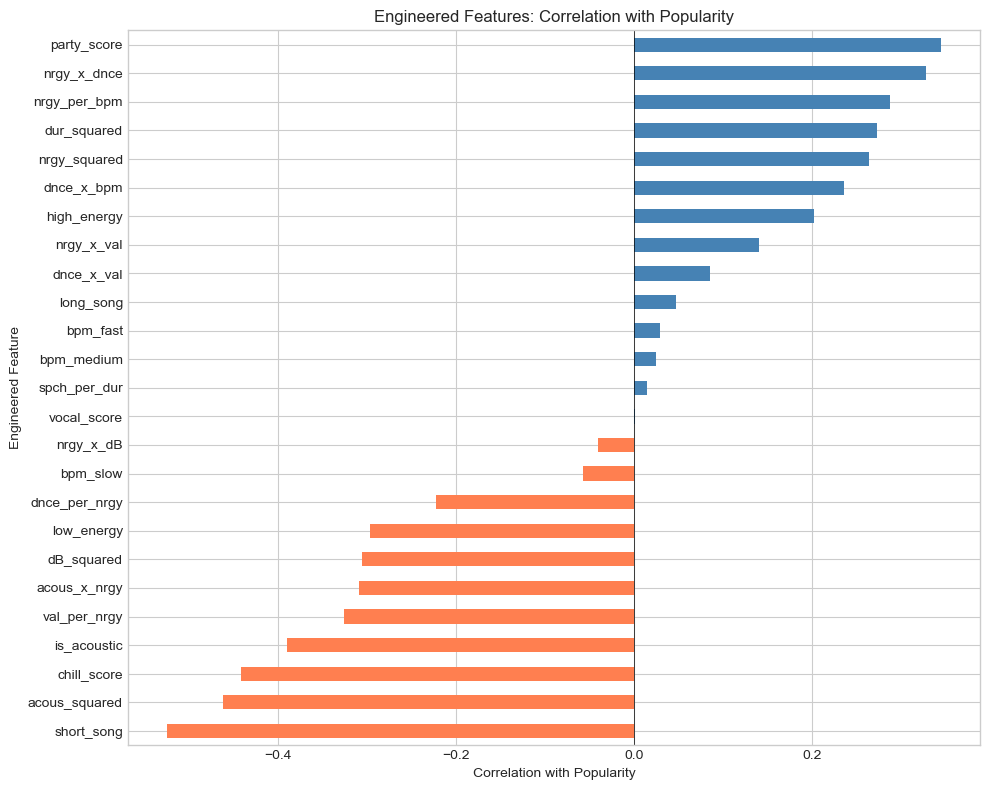

In [8]:
# Visualize top correlations
plt.figure(figsize=(10, 8))
correlations.sort_values().plot(kind='barh', color=['coral' if x < 0 else 'steelblue' for x in correlations.sort_values()])
plt.xlabel('Correlation with Popularity')
plt.ylabel('Engineered Feature')
plt.title('Engineered Features: Correlation with Popularity')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

---
## 4. Prepare Feature Sets

We'll test different feature combinations.

In [9]:
# Define feature sets
genre_features = [col for col in train_fe.columns if col.startswith('genre_') and col != 'genre_simplified']

# Feature set 1: Approach 1 baseline (numerical + genre)
features_baseline = numerical_features + genre_features

# Feature set 2: All features (numerical + genre + engineered)
features_all = numerical_features + genre_features + engineered_features

# Feature set 3: Numerical + engineered only (no genre)
features_no_genre = numerical_features + engineered_features

# Feature set 4: Select best engineered features (correlation > 0.1)
best_engineered = correlations[abs(correlations) > 0.1].index.tolist()
features_selected = numerical_features + genre_features + best_engineered

print("="*60)
print("FEATURE SETS TO TEST")
print("="*60)
print(f"\n1. Baseline (Approach 1):     {len(features_baseline)} features")
print(f"2. All features:               {len(features_all)} features")
print(f"3. No genre (num + eng):       {len(features_no_genre)} features")
print(f"4. Selected (corr > 0.1):      {len(features_selected)} features")
print(f"\nBest engineered features (|corr| > 0.1): {best_engineered}")

FEATURE SETS TO TEST

1. Baseline (Approach 1):     25 features
2. All features:               50 features
3. No genre (num + eng):       34 features
4. Selected (corr > 0.1):      42 features

Best engineered features (|corr| > 0.1): ['short_song', 'acous_squared', 'chill_score', 'is_acoustic', 'party_score', 'nrgy_x_dnce', 'val_per_nrgy', 'acous_x_nrgy', 'dB_squared', 'low_energy', 'nrgy_per_bpm', 'dur_squared', 'nrgy_squared', 'dnce_x_bpm', 'dnce_per_nrgy', 'high_energy', 'nrgy_x_val']


---
## 5. Model Training and Comparison

In [10]:
# Helper function
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_feature_set(X, y, feature_set_name):
    """
    Evaluate Random Forest on a feature set using cross-validation.
    """
    # Train-val split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale numerical features
    scaler = StandardScaler()
    num_cols = [c for c in X.columns if c in numerical_features + engineered_features]
    
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_val_scaled[num_cols] = scaler.transform(X_val[num_cols])
    
    # Train Random Forest
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    model.fit(X_train.values, y_train)
    
    # Evaluate
    val_pred = model.predict(X_val.values)
    val_rmse = calculate_rmse(y_val, val_pred)
    val_r2 = r2_score(y_val, val_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X.values, y, cv=5, scoring='neg_root_mean_squared_error')
    cv_rmse = -cv_scores.mean()
    cv_std = cv_scores.std()
    
    return {
        'Feature Set': feature_set_name,
        'Num Features': X.shape[1],
        'Val RMSE': val_rmse,
        'CV RMSE': cv_rmse,
        'CV Std': cv_std,
        'Val R2': val_r2,
        'model': model
    }

In [11]:
# Prepare target
y = train_fe['pop'].copy()

# Evaluate each feature set
print("="*70)
print("EVALUATING FEATURE SETS (Random Forest)")
print("="*70)

results = []

feature_sets = {
    'Baseline (Approach 1)': features_baseline,
    'All Features': features_all,
    'No Genre': features_no_genre,
    'Selected Features': features_selected
}

for name, features in feature_sets.items():
    print(f"\nEvaluating: {name}...")
    X = train_fe[features].copy()
    result = evaluate_feature_set(X, y, name)
    results.append(result)
    print(f"  CV RMSE: {result['CV RMSE']:.4f} (+/- {result['CV Std']:.4f})")
    print(f"  Val R²:  {result['Val R2']:.4f}")

EVALUATING FEATURE SETS (Random Forest)

Evaluating: Baseline (Approach 1)...


  CV RMSE: 10.9346 (+/- 0.8644)
  Val R²:  0.4369

Evaluating: All Features...


  CV RMSE: 11.1109 (+/- 0.6970)
  Val R²:  0.3855

Evaluating: No Genre...


  CV RMSE: 11.3579 (+/- 0.7183)
  Val R²:  0.3433

Evaluating: Selected Features...


  CV RMSE: 11.1107 (+/- 0.8107)
  Val R²:  0.3914


In [12]:
# Results comparison
results_df = pd.DataFrame(results).drop(columns=['model'])
results_df = results_df.sort_values('CV RMSE')

print("="*70)
print("FEATURE SET COMPARISON (sorted by CV RMSE)")
print("="*70)
print(results_df.to_string(index=False))

FEATURE SET COMPARISON (sorted by CV RMSE)
          Feature Set  Num Features  Val RMSE   CV RMSE   CV Std   Val R2
Baseline (Approach 1)            25 11.223352 10.934607 0.864427 0.436852
    Selected Features            42 11.667456 11.110744 0.810736 0.391403
         All Features            50 11.723762 11.110870 0.697009 0.385515
             No Genre            34 12.119351 11.357866 0.718302 0.343347


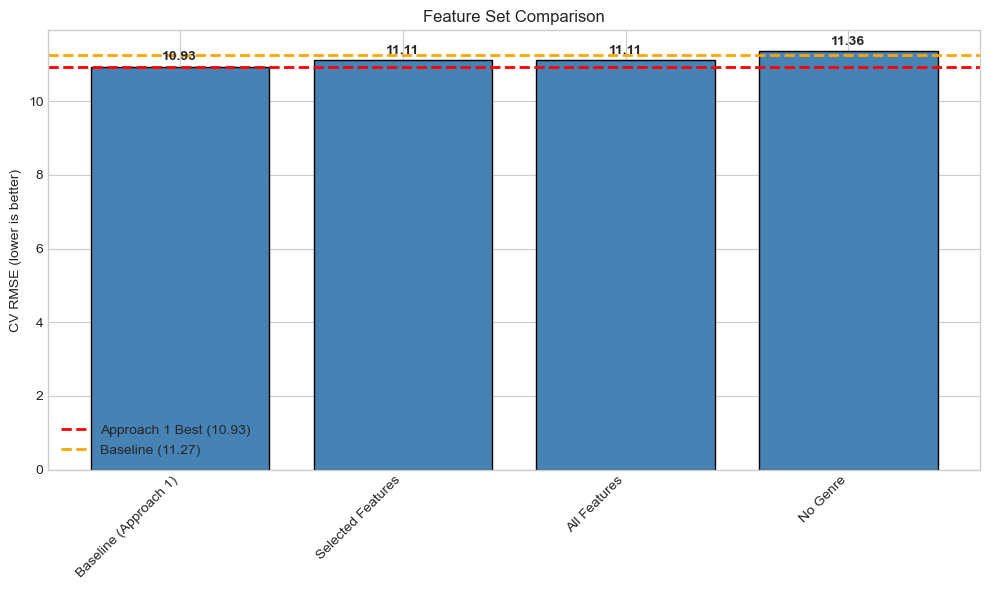

In [13]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(results_df))
bars = ax.bar(x, results_df['CV RMSE'], color='steelblue', edgecolor='black')
ax.axhline(y=10.9261, color='red', linestyle='--', linewidth=2, label='Approach 1 Best (10.93)')
ax.axhline(y=11.27, color='orange', linestyle='--', linewidth=2, label='Baseline (11.27)')

ax.set_ylabel('CV RMSE (lower is better)')
ax.set_title('Feature Set Comparison')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Feature Set'], rotation=45, ha='right')
ax.legend()

# Add value labels on bars
for bar, val in zip(bars, results_df['CV RMSE']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
            f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

---
## 6. Try Different Models with Best Feature Set

In [14]:
# Identify best feature set
best_feature_set_name = results_df.iloc[0]['Feature Set']
best_features = feature_sets[best_feature_set_name]

print(f"Best feature set: {best_feature_set_name}")
print(f"Number of features: {len(best_features)}")

Best feature set: Baseline (Approach 1)
Number of features: 25


In [15]:
# Prepare data with best features
X = train_fe[best_features].copy()
X_test = test_fe[best_features].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
num_cols = [c for c in X.columns if c in numerical_features + engineered_features]

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_full_scaled = X.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val_scaled[num_cols] = scaler.transform(X_val[num_cols])

scaler_full = StandardScaler()
X_full_scaled[num_cols] = scaler_full.fit_transform(X[num_cols])
X_test_scaled[num_cols] = scaler_full.transform(X_test[num_cols])

print("Data prepared for model comparison")

Data prepared for model comparison


In [16]:
# Test multiple models
models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Random Forest (deeper)': RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    'Gradient Boosting (tuned)': GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.05, random_state=42)
}

model_results = []

print("="*70)
print(f"MODEL COMPARISON WITH {best_feature_set_name.upper()}")
print("="*70)

for name, model in models.items():
    print(f"\n--- {name} ---")
    
    # Use scaled for linear, unscaled for tree-based
    if 'Forest' in name or 'Boosting' in name:
        X_tr, X_va, X_full = X_train.values, X_val.values, X.values
    else:
        X_tr, X_va, X_full = X_train_scaled.values, X_val_scaled.values, X_full_scaled.values
    
    model.fit(X_tr, y_train)
    
    val_pred = model.predict(X_va)
    val_rmse = calculate_rmse(y_val, val_pred)
    val_r2 = r2_score(y_val, val_pred)
    
    cv_scores = cross_val_score(model, X_full, y, cv=5, scoring='neg_root_mean_squared_error')
    cv_rmse = -cv_scores.mean()
    cv_std = cv_scores.std()
    
    model_results.append({
        'Model': name,
        'Val RMSE': val_rmse,
        'CV RMSE': cv_rmse,
        'CV Std': cv_std,
        'Val R2': val_r2
    })
    
    print(f"  CV RMSE: {cv_rmse:.4f} (+/- {cv_std:.4f})")
    print(f"  Val R²:  {val_r2:.4f}")

MODEL COMPARISON WITH BASELINE (APPROACH 1)

--- Ridge ---
  CV RMSE: 10.8020 (+/- 0.9502)
  Val R²:  0.3985

--- Lasso ---
  CV RMSE: 10.8086 (+/- 0.8766)
  Val R²:  0.4221

--- ElasticNet ---
  CV RMSE: 11.0047 (+/- 1.0222)
  Val R²:  0.3953

--- Random Forest ---


  CV RMSE: 10.9346 (+/- 0.8644)
  Val R²:  0.4369

--- Random Forest (deeper) ---


  CV RMSE: 10.9688 (+/- 0.8148)
  Val R²:  0.4275

--- Gradient Boosting ---


  CV RMSE: 11.1170 (+/- 0.9586)
  Val R²:  0.4048

--- Gradient Boosting (tuned) ---


  CV RMSE: 10.9199 (+/- 0.7042)
  Val R²:  0.4013


In [17]:
# Model comparison summary
model_results_df = pd.DataFrame(model_results).sort_values('CV RMSE')

print("="*70)
print("MODEL COMPARISON SUMMARY (sorted by CV RMSE)")
print("="*70)
print(model_results_df.round(4).to_string(index=False))

MODEL COMPARISON SUMMARY (sorted by CV RMSE)
                    Model  Val RMSE  CV RMSE  CV Std  Val R2
                    Ridge   11.5995  10.8020  0.9502  0.3985
                    Lasso   11.3694  10.8086  0.8766  0.4221
Gradient Boosting (tuned)   11.5719  10.9199  0.7042  0.4013
            Random Forest   11.2234  10.9346  0.8644  0.4369
   Random Forest (deeper)   11.3158  10.9688  0.8148  0.4275
               ElasticNet   11.6296  11.0047  1.0222  0.3953
        Gradient Boosting   11.5379  11.1170  0.9586  0.4048


---
## 7. Feature Importance (Best Model)

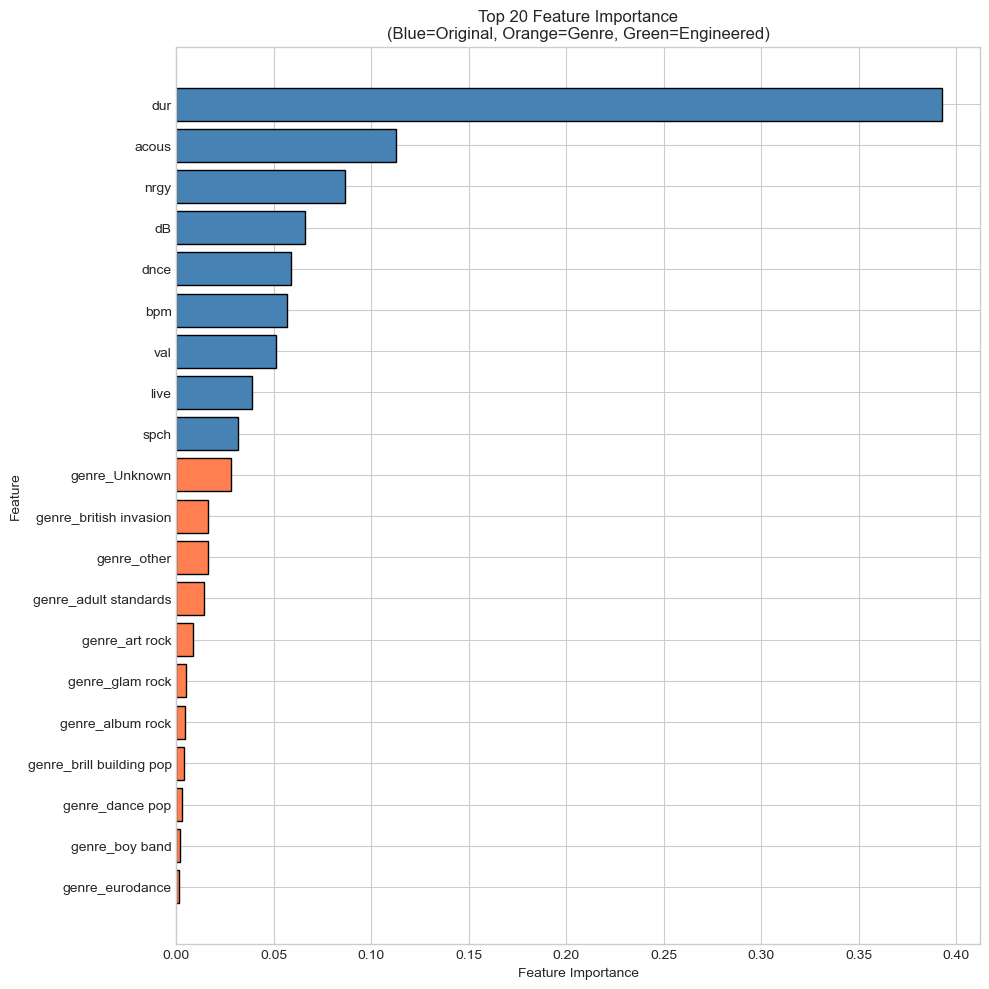

In [18]:
# Train best model for feature importance
best_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
best_model.fit(X.values, y)

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': best_features,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=True)

# Categorize features
def categorize_feature(f):
    if f.startswith('genre_'):
        return 'Genre'
    elif f in numerical_features:
        return 'Original'
    else:
        return 'Engineered'

feature_importance['Type'] = feature_importance['Feature'].apply(categorize_feature)

# Plot top 20
top_20 = feature_importance.tail(20)

plt.figure(figsize=(10, 10))
colors = {'Original': 'steelblue', 'Genre': 'coral', 'Engineered': 'green'}
bar_colors = [colors[t] for t in top_20['Type']]
plt.barh(top_20['Feature'], top_20['Importance'], color=bar_colors, edgecolor='black')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance\n(Blue=Original, Orange=Genre, Green=Engineered)')
plt.tight_layout()
plt.show()

In [19]:
# Importance by feature type
importance_by_type = feature_importance.groupby('Type')['Importance'].sum()

print("="*60)
print("IMPORTANCE BY FEATURE TYPE")
print("="*60)
for ftype, imp in importance_by_type.items():
    print(f"{ftype}: {imp:.4f} ({imp*100:.1f}%)")

IMPORTANCE BY FEATURE TYPE
Genre: 0.1048 (10.5%)
Original: 0.8952 (89.5%)


---
## 8. Final Model and Predictions

In [20]:
# Get best model from comparison
best_model_name = model_results_df.iloc[0]['Model']
best_cv_rmse = model_results_df.iloc[0]['CV RMSE']
best_val_r2 = model_results_df.iloc[0]['Val R2']

print(f"Best Model: {best_model_name}")
print(f"CV RMSE: {best_cv_rmse:.4f}")
print(f"Val R²: {best_val_r2:.4f}")

Best Model: Ridge
CV RMSE: 10.8020
Val R²: 0.3985


In [21]:
# Train final model
final_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
final_model.fit(X.values, y)

# Generate predictions
test_predictions = final_model.predict(X_test.values)

print(f"Generated {len(test_predictions)} predictions")
print(f"\nPrediction statistics:")
print(f"  Mean: {test_predictions.mean():.2f}")
print(f"  Std:  {test_predictions.std():.2f}")
print(f"  Min:  {test_predictions.min():.2f}")
print(f"  Max:  {test_predictions.max():.2f}")

Generated 114 predictions

Prediction statistics:
  Mean: 61.56
  Std:  7.70
  Min:  40.23
  Max:  72.74


In [22]:
# Create submission file
submission = pd.DataFrame({
    'Id': test_fe['Id'],
    'pop': test_predictions
})

submission.to_csv('./submission_approach3_feature_engineering.csv', index=False)

print("="*60)
print("SUBMISSION FILE CREATED")
print("="*60)
print(f"File: ./submission_approach3_feature_engineering.csv")
print(f"\nFirst 10 predictions:")
print(submission.head(10))

SUBMISSION FILE CREATED
File: ./submission_approach3_feature_engineering.csv

First 10 predictions:
    Id        pop
0  454  68.175573
1  455  69.498686
2  456  54.223064
3  457  63.522468
4  458  49.859652
5  459  66.542324
6  460  58.568306
7  461  41.832626
8  462  65.784177
9  463  63.085413


---
## 9. Summary: All Approaches Comparison

In [23]:
# Final comparison of all approaches
print("="*70)
print("FINAL COMPARISON: ALL APPROACHES")
print("="*70)

all_approaches = pd.DataFrame([
    {'Approach': 'Baseline (no genre)', 'CV RMSE': 11.27, 'Val R²': 0.39, 'Features': 9},
    {'Approach': 'Approach 1 (top 15 genres)', 'CV RMSE': 10.93, 'Val R²': 0.41, 'Features': 25},
    {'Approach': 'Approach 2 (hybrid groups)', 'CV RMSE': 11.05, 'Val R²': 0.35, 'Features': 19},
    {'Approach': 'Approach 3 (feature engineering)', 'CV RMSE': best_cv_rmse, 'Val R²': best_val_r2, 'Features': len(best_features)}
]).sort_values('CV RMSE')

print(all_approaches.to_string(index=False))

print(f"\n{'='*70}")
print(f"BEST APPROACH: {all_approaches.iloc[0]['Approach']}")
print(f"CV RMSE: {all_approaches.iloc[0]['CV RMSE']:.4f}")
print("="*70)

FINAL COMPARISON: ALL APPROACHES
                        Approach   CV RMSE  Val R²  Features
Approach 3 (feature engineering) 10.802034 0.39847        25
      Approach 1 (top 15 genres) 10.930000 0.41000        25
      Approach 2 (hybrid groups) 11.050000 0.35000        19
             Baseline (no genre) 11.270000 0.39000         9

BEST APPROACH: Approach 3 (feature engineering)
CV RMSE: 10.8020


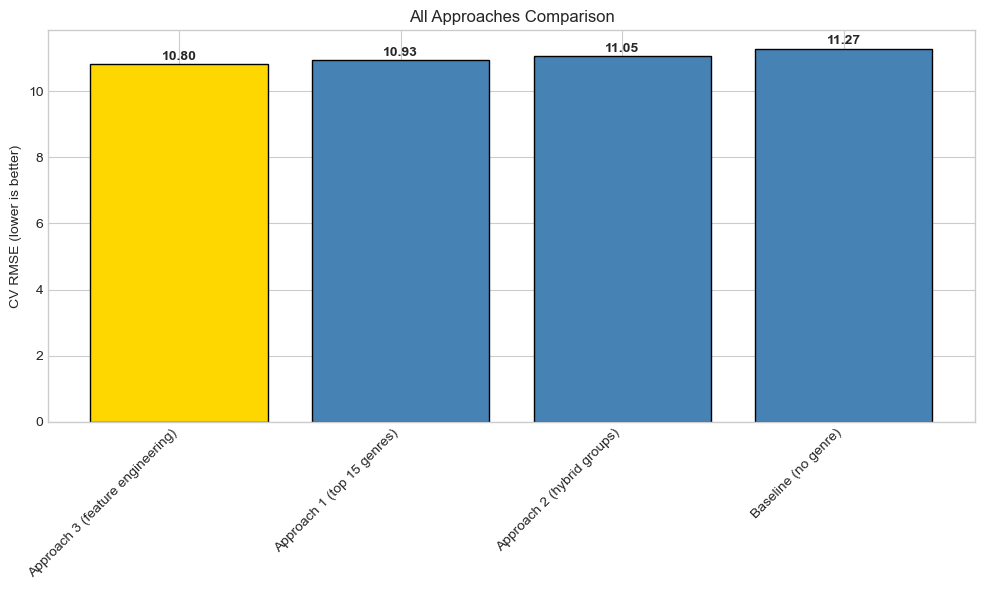

In [24]:
# Visualize all approaches
plt.figure(figsize=(10, 6))
colors = ['gold' if i == 0 else 'steelblue' for i in range(len(all_approaches))]
bars = plt.bar(all_approaches['Approach'], all_approaches['CV RMSE'], color=colors, edgecolor='black')
plt.ylabel('CV RMSE (lower is better)')
plt.title('All Approaches Comparison')
plt.xticks(rotation=45, ha='right')

for bar, val in zip(bars, all_approaches['CV RMSE']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()